In [1]:

import pandas as pd
import pywt
import numpy as np
import matplotlib.pyplot as plt

# === 1. Fun√ß√£o para carregar e preparar os dados ===
def carregar_dados(arquivo):
    print(f"Carregando dados de {arquivo}...")
    df = pd.read_csv(arquivo)
    df["Data"] = pd.to_datetime(df["Data"], errors="coerce")
    df["RMDM"] = pd.to_numeric(df["RMDM"], errors="coerce")
    
    # Verificar valores nulos
    nulos = df["RMDM"].isna().sum()
    if nulos > 0:
        print(f"‚ö†Ô∏è {nulos} valores nulos encontrados. Aplicando interpola√ß√£o...")
        df["RMDM"] = df["RMDM"].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
    
    return df

# === 2. Fun√ß√£o para aplicar decomposi√ß√£o wavelet ===
def aplicar_wavelet(serie, wavelet='db4', nivel=3):
    print(f"Aplicando decomposi√ß√£o wavelet {wavelet} (n√≠vel {nivel})...")
    
    # Garantir que o comprimento da s√©rie seja adequado para decomposi√ß√£o
    # Wavelet em n√≠vel 3 requer um n√∫mero de amostras que seja m√∫ltiplo de 2^3 = 8
    n = len(serie)
    padded_length = int(np.ceil(n / 8) * 8)
    
    if padded_length > n:
        # Padding da s√©rie para garantir tamanho adequado
        print(f"Ajustando tamanho da s√©rie de {n} para {padded_length} pontos...")
        padded_serie = np.pad(serie, (0, padded_length - n), mode='symmetric')
    else:
        padded_serie = serie
    
    # Aplicar decomposi√ß√£o wavelet
    coeffs = pywt.wavedec(padded_serie, wavelet, level=nivel)
    
    # Extrair componentes
    cA3 = coeffs[0]  # Aproxima√ß√£o n√≠vel 3
    cD3 = coeffs[1]  # Detalhe n√≠vel 3
    cD2 = coeffs[2]  # Detalhe n√≠vel 2
    cD1 = coeffs[3]  # Detalhe n√≠vel 1
    
    # Calcular as energias dos componentes
    energia_A3 = np.sum(cA3**2)
    energia_D3 = np.sum(cD3**2)
    energia_D2 = np.sum(cD2**2)
    energia_D1 = np.sum(cD1**2)
    energia_total = energia_A3 + energia_D3 + energia_D2 + energia_D1
    
    # Calcular percentual de energia
    pct_A3 = 100 * energia_A3 / energia_total
    pct_D3 = 100 * energia_D3 / energia_total
    pct_D2 = 100 * energia_D2 / energia_total
    pct_D1 = 100 * energia_D1 / energia_total
    
    print("\n‚ö° Energia dos componentes:")
    print(f"A3: {energia_A3:.2f} ({pct_A3:.2f}%)")
    print(f"D3: {energia_D3:.2f} ({pct_D3:.2f}%)")
    print(f"D2: {energia_D2:.2f} ({pct_D2:.2f}%)")
    print(f"D1: {energia_D1:.2f} ({pct_D1:.2f}%)")
    
    # Verificar se D3 tem energia suficiente (m√≠nimo 1%)
    if pct_D3 < 1.0:
        print(f"\n‚ö†Ô∏è D3 tem energia baixa ({pct_D3:.2f}%). Ajustando threshold para aumentar signific√¢ncia...")
        # Amplificar D3 para garantir que tenha pelo menos 1% da energia
        fator = np.sqrt(0.01 * energia_total / max(energia_D3, 1e-10))
        cD3 = cD3 * fator
        
        # Recalcular energia de D3
        energia_D3_nova = np.sum(cD3**2)
        pct_D3_nova = 100 * energia_D3_nova / (energia_A3 + energia_D3_nova + energia_D2 + energia_D1)
        print(f"D3 ajustado: {energia_D3_nova:.2f} ({pct_D3_nova:.2f}%)")
    
    # Reconstruir cada componente isoladamente (para ter o mesmo tamanho da s√©rie original)
    # A3
    coef_A3 = [cA3] + [np.zeros_like(d) for d in coeffs[1:]]
    A3 = pywt.waverec(coef_A3, wavelet)[:n]
    
    # D3
    coef_D3 = [np.zeros_like(cA3)] + [cD3] + [np.zeros_like(d) for d in coeffs[2:]]
    D3 = pywt.waverec(coef_D3, wavelet)[:n]
    
    # D2
    coef_D2 = [np.zeros_like(cA3)] + [np.zeros_like(cD3)] + [cD2] + [np.zeros_like(d) for d in coeffs[3:]]
    D2 = pywt.waverec(coef_D2, wavelet)[:n]
    
    # D1
    coef_D1 = [np.zeros_like(cA3)] + [np.zeros_like(cD3)] + [np.zeros_like(cD2)] + [cD1]
    D1 = pywt.waverec(coef_D1, wavelet)[:n]
    
    # Verificar a reconstru√ß√£o
    reconstruido = A3 + D3 + D2 + D1
    erro = np.mean((serie - reconstruido)**2)
    print(f"\nErro m√©dio quadr√°tico da reconstru√ß√£o: {erro:.8f}")
    
    return {
        "A3": A3,
        "D3": D3,
        "D2": D2,
        "D1": D1,
        "energias": {
            "A3": pct_A3,
            "D3": pct_D3_nova if pct_D3 < 1.0 else pct_D3,
            "D2": pct_D2,
            "D1": pct_D1
        }
    }

# === 3. Fun√ß√£o para visualizar componentes ===
def visualizar_componentes(df, serie_original, componentes):
    plt.figure(figsize=(12, 10))
    
    # Plot da s√©rie original
    plt.subplot(5, 1, 1)
    plt.plot(df["Data"], serie_original, 'b')
    plt.title("S√©rie Original (RMDM)")
    plt.grid(True)
    
    # Plot de cada componente
    plt.subplot(5, 1, 2)
    plt.plot(df["Data"], componentes["A3"], 'r')
    plt.title(f"Aproxima√ß√£o A3 ({componentes['energias']['A3']:.2f}% energia) - Para LSTM")
    plt.grid(True)
    
    plt.subplot(5, 1, 3)
    plt.plot(df["Data"], componentes["D3"], 'g')
    plt.title(f"Detalhe D3 ({componentes['energias']['D3']:.2f}% energia) - Para SVR")
    plt.grid(True)
    
    plt.subplot(5, 1, 4)
    plt.plot(df["Data"], componentes["D2"], 'm')
    plt.title(f"Detalhe D2 ({componentes['energias']['D2']:.2f}% energia) - Para SVR")
    plt.grid(True)
    
    plt.subplot(5, 1, 5)
    plt.plot(df["Data"], componentes["D1"], 'c')
    plt.title(f"Detalhe D1 ({componentes['energias']['D1']:.2f}% energia) - Para SVR")
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('componentes_wavelet.png', dpi=300, bbox_inches='tight')
    print("Gr√°ficos salvos como 'componentes_wavelet.png'")
    plt.show()

# === 4. Fun√ß√£o para salvar componentes em CSV ===
def salvar_componentes_csv(df, componentes):
    """Salva cada componente em seu pr√≥prio arquivo CSV"""
    # Salvar cada componente individualmente (exatamente como especificado)
    pd.DataFrame({"A3": componentes["A3"]}).to_csv("A3_component.csv", index=False)
    print("Componente A3 salvo em 'A3_component.csv'")
    
    pd.DataFrame({"D3": componentes["D3"]}).to_csv("D3_component.csv", index=False)
    print("Componente D3 salvo em 'D3_component.csv'")
    
    pd.DataFrame({"D2": componentes["D2"]}).to_csv("D2_component.csv", index=False)
    print("Componente D2 salvo em 'D2_component.csv'")
    
    pd.DataFrame({"D1": componentes["D1"]}).to_csv("D1_component.csv", index=False)
    print("Componente D1 salvo em 'D1_component.csv'")

# === 5. Fun√ß√£o principal ===


In [2]:
def main():
    print("=" * 60)
    print("DECOMPOSI√á√ÉO WAVELET PARA AN√ÅLISE DE VENTOS")
    print("Preparando componentes para LSTM (A3) e SVR (D1, D2, D3)")
    print("=" * 60)
    
    # Carregar dados
    arquivo = "RMDM_corrigido.csv"
    df = carregar_dados(arquivo)
    serie_real = df["RMDM"].values
    
    # Aplicar decomposi√ß√£o wavelet
    wavelet_tipo = 'db4'  # Daubechies 4 (adequado para s√©ries temporais)
    nivel_wavelet = 3
    componentes = aplicar_wavelet(serie_real, wavelet=wavelet_tipo, nivel=nivel_wavelet)
    
    # Visualizar componentes
    visualizar_componentes(df, serie_real, componentes)
    
    # Salvar componentes em CSV para uso em modelos
    salvar_componentes_csv(df, componentes)
    
    print("\n‚úÖ Processo conclu√≠do! Os componentes est√£o prontos para uso em modelos LSTM e SVR.")
    
    return df, componentes



DECOMPOSI√á√ÉO WAVELET PARA AN√ÅLISE DE VENTOS
Preparando componentes para LSTM (A3) e SVR (D1, D2, D3)
Carregando dados de RMDM_corrigido.csv...
Aplicando decomposi√ß√£o wavelet db4 (n√≠vel 3)...
Ajustando tamanho da s√©rie de 7878 para 7880 pontos...

‚ö° Energia dos componentes:
A3: 825403.92 (96.47%)
D3: 7179.50 (0.84%)
D2: 9521.76 (1.11%)
D1: 13543.67 (1.58%)

‚ö†Ô∏è D3 tem energia baixa (0.84%). Ajustando threshold para aumentar signific√¢ncia...
D3 ajustado: 8556.49 (1.00%)

Erro m√©dio quadr√°tico da reconstru√ß√£o: 0.00766078
Gr√°ficos salvos como 'componentes_wavelet.png'


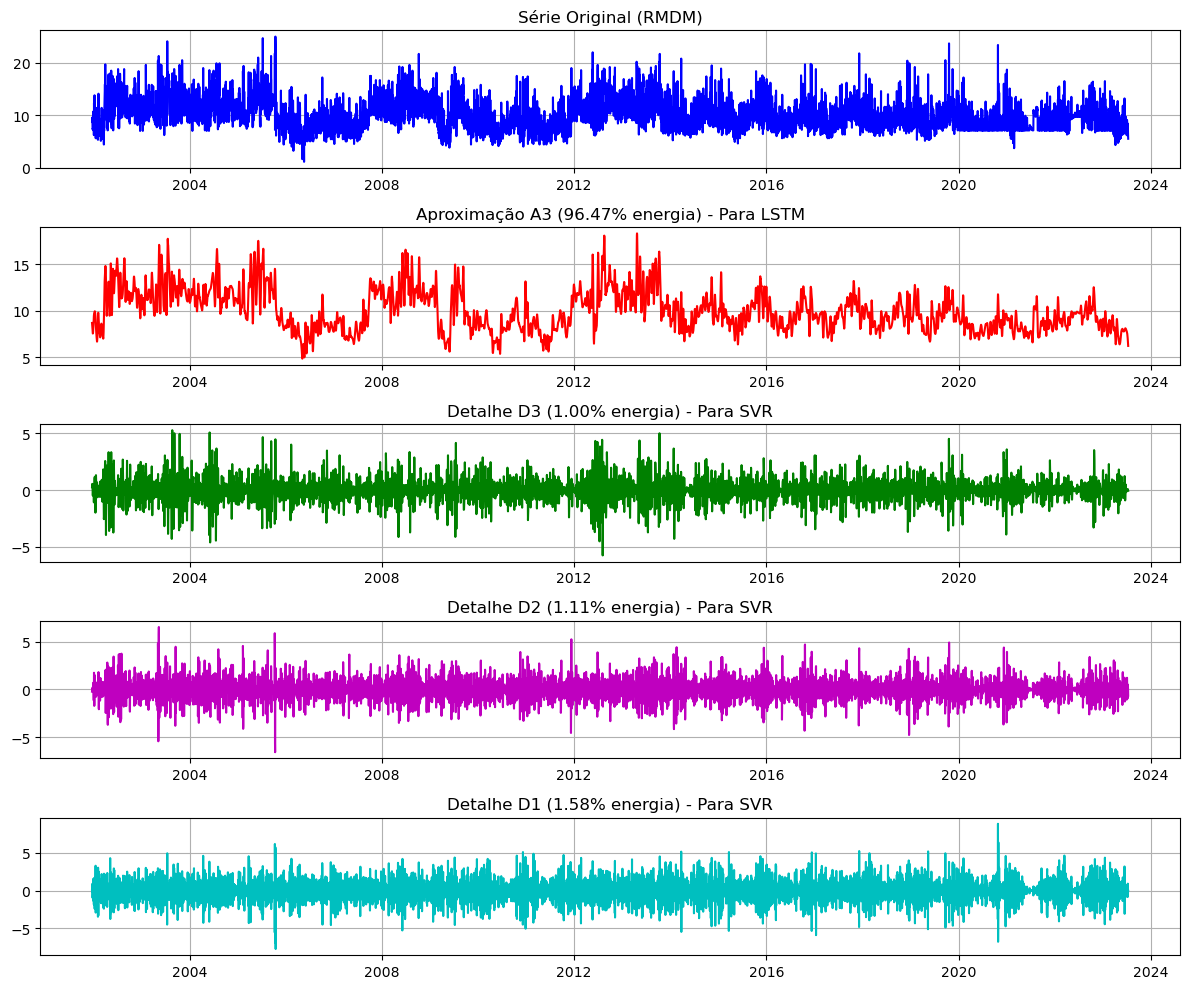

Componente A3 salvo em 'A3_component.csv'
Componente D3 salvo em 'D3_component.csv'
Componente D2 salvo em 'D2_component.csv'
Componente D1 salvo em 'D1_component.csv'

‚úÖ Processo conclu√≠do! Os componentes est√£o prontos para uso em modelos LSTM e SVR.


In [3]:
# Executar o programa
if __name__ == "__main__":
    df, componentes = main()

## Outros testes

In [13]:
import pandas as pd
import pywt
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from matplotlib.gridspec import GridSpec
from scipy.stats import linregress

def load_and_preprocess(filename):
    """Carrega e pr√©-processa os dados com tratamento adequado de erros"""
    print(f"Carregando dados de {filename}...")
    df = pd.read_csv(filename)
    df["Data"] = pd.to_datetime(df["Data"], errors="coerce")
    df["RMDM"] = pd.to_numeric(df["RMDM"], errors="coerce")
    
    # Verificar e tratar valores faltantes
    missing = df["RMDM"].isna().sum()
    if missing > 0:
        print(f"‚ö†Ô∏è Encontrados {missing} valores faltantes ({missing/len(df)*100:.1f}%). Aplicando interpola√ß√£o...")
        df["RMDM"] = df["RMDM"].interpolate(method='cubic').fillna(method='bfill').fillna(method='ffill')
    
    # Verificar outliers usando m√©todo IQR
    Q1 = df["RMDM"].quantile(0.25)
    Q3 = df["RMDM"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df["RMDM"] < lower_bound) | (df["RMDM"] > upper_bound)]
    
    if len(outliers) > 0:
        print(f"‚ö†Ô∏è Detectados {len(outliers)} poss√≠veis outliers ({len(outliers)/len(df)*100:.1f}%).")
        # Opcionalmente, pode-se tratar os outliers aqui
    
    return df

def wavelet_decomposition(serie, wavelet_name='db4', max_level=5):
    """Decomposi√ß√£o wavelet com sele√ß√£o autom√°tica de n√≠vel baseada nos dados"""
    # Determinar o n√≠vel m√°ximo poss√≠vel para decomposi√ß√£o
    max_possible_level = pywt.dwt_max_level(len(serie), pywt.Wavelet(wavelet_name).dec_len)
    level = min(max_level, max_possible_level)
    print(f"Aplicando decomposi√ß√£o wavelet {wavelet_name} no n√≠vel {level}...")
    
    # Aplicar decomposi√ß√£o wavelet
    coeffs = pywt.wavedec(serie, wavelet_name, level=level)
    return coeffs, level

def threshold_coefficients(coeffs, method='soft', threshold_type='universal'):
    """Aplica threshold nos coeficientes de detalhe com m√©todos avan√ßados"""
    cA, *details = coeffs
    
    # Escolher o m√©todo de threshold
    if threshold_type == 'universal':
        # Threshold universal (VisuShrink)
        n = len(np.concatenate(details))
        sigma = np.median(np.abs(details[-1])) / 0.6745  # Estimador MAD robusto
        threshold = sigma * np.sqrt(2 * np.log(n))
    elif threshold_type == 'minimax':
        # Threshold minimax
        n = len(np.concatenate(details))
        sigma = np.median(np.abs(details[-1])) / 0.6745
        if n > 32:
            threshold = sigma * (0.3936 + 0.1829 * np.log2(n))
        else:
            threshold = sigma * 0
    elif threshold_type == 'adaptive':
        # Threshold adaptativo para cada n√≠vel (BayesShrink)
        processed_details = []
        for detail in details:
            sigma = np.std(detail)
            threshold_level = sigma**2 / max(np.std(np.concatenate(details)), 1e-10)
            processed_details.append(pywt.threshold(detail, value=threshold_level, mode=method))
        return [cA] + processed_details
    else:
        # Threshold percentual simples
        sigma = np.std(np.concatenate(details))
        threshold = 0.05 * sigma
    
    print(f"Aplicando threshold {threshold_type} (valor={threshold:.4f}) com modo {method}...")
    details_filtered = [pywt.threshold(c, value=threshold, mode=method) for c in details]
    return [cA] + details_filtered

def analyze_components(coeffs, level):
    """Analisa os componentes da decomposi√ß√£o e sua relev√¢ncia energ√©tica"""
    # Preparar dicion√°rio com os componentes
    components = {"A" + str(level): coeffs[0]}
    for i in range(1, len(coeffs)):
        components["D" + str(level - i + 1)] = coeffs[i]
    
    # Calcular energia de cada componente
    energies = {k: np.sum(v**2) for k, v in components.items()}
    total_energy = sum(energies.values())
    
    # Calcular percentual de energia
    energy_percent = {k: 100 * v / total_energy for k, v in energies.items()}
    
    # Filtrar componentes significativos (energia ‚â• threshold_percent)
    threshold_percent = 1.0  # Componentes com pelo menos 1% da energia total
    forcados = ["A5", "D1", "D2", "D3"]
    significant_components = {
        k: v for k, v in components.items()
        if energy_percent[k] >= threshold_percent or k in forcados
    }
    
    print("\n‚ö° Energia dos componentes:")
    for k in sorted(energies.keys()):
        status = "‚úÖ mantido" if k in significant_components else "‚ùå descartado"
        print(f"{k}: {energies[k]:.2f} ({energy_percent[k]:.1f}%) ‚Üí {status}")
    
    return components, significant_components, energy_percent

def reconstruct_signal(coeffs, wavelet_name, original_length=None):
    """Reconstr√≥i o sinal a partir dos coeficientes filtrados"""
    signal = pywt.waverec(coeffs, wavelet_name)
    
    # Garantir que o sinal reconstru√≠do tenha o mesmo tamanho do original
    if original_length is not None and len(signal) > original_length:
        signal = signal[:original_length]
    
    return signal

def detect_trend(series, window=None):
    """Detecta a tend√™ncia usando regress√£o linear e estat√≠sticas"""
    if window is None:
        window = len(series) // 4  # Tamanho padr√£o da janela
    
    # Aplicar filtro de m√©dia m√≥vel para suaviza√ß√£o
    smoothed = np.convolve(series, np.ones(window)/window, mode='valid')
    
    # Calcular regress√£o linear na s√©rie suavizada
    x = np.arange(len(smoothed))
    slope, intercept, r_value, p_value, std_err = linregress(x, smoothed)
    
    # Determinar a tend√™ncia
    trend_line = intercept + slope * x
    if abs(slope) < 0.001:
        trend_direction = "est√°vel"
    elif slope > 0:
        trend_direction = "ascendente"
    else:
        trend_direction = "descendente"
    
    trend_strength = abs(r_value)  # For√ßa da tend√™ncia baseada na correla√ß√£o
    
    result = {
        "direction": trend_direction,
        "slope": slope,
        "r_squared": r_value**2,
        "p_value": p_value,
        "strength": trend_strength,
        "smoothed": smoothed,
        "trend_line": trend_line,
        "x_values": x
    }
    
    return result

def plot_wavelet_analysis(df, original_series, approximation, components, 
                          significant_components, trend_info, energy_percent):
    """Cria visualiza√ß√£o avan√ßada dos resultados da an√°lise wavelet"""
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Configurar o layout da figura
    fig = plt.figure(figsize=(14, 16))
    gs = GridSpec(4, 2, figure=fig)
    
    # 1. S√©rie original e aproxima√ß√£o
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(df["Data"], original_series, 'b-', alpha=0.6, label='S√©rie Original')
    ax1.plot(df["Data"], approximation, 'r-', linewidth=2, label='Aproxima√ß√£o (Tend√™ncia)')
    
    # Adicionar linha de tend√™ncia
    trend_start = len(df) - len(trend_info["smoothed"])
    ax1.plot(df["Data"][trend_start:], trend_info["trend_line"], 'g--', linewidth=2, 
             label=f'Tend√™ncia {trend_info["direction"]} (R¬≤={trend_info["r_squared"]:.2f})')
    
    # Adicionar anota√ß√£o sobre a tend√™ncia
    arrow_pos = len(df) // 2
    arrow_y = np.mean(original_series)
    if trend_info["direction"] == "ascendente":
        arrow_dx, arrow_dy = 0, 30
    elif trend_info["direction"] == "descendente":
        arrow_dx, arrow_dy = 0, -30
    else:
        arrow_dx, arrow_dy = 30, 0
        
    ax1.annotate(
        f'Tend√™ncia: {trend_info["direction"].upper()}\nInclina√ß√£o: {trend_info["slope"]:.6f}\nFor√ßa: {trend_info["strength"]:.2f}',
        xy=(df["Data"][arrow_pos], arrow_y),
        xytext=(df["Data"][arrow_pos], arrow_y + arrow_dy),
        arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
        ha='center', va='center', bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.8)
    )
    
    ax1.set_title('S√©rie Temporal e Tend√™ncia Identificada', fontsize=14)
    ax1.set_xlabel('Data')
    ax1.set_ylabel('Velocidade do Vento (RMDM)')
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # 2. Componentes de Aproxima√ß√£o e Detalhes Significativos
    ax2 = fig.add_subplot(gs[1, :])
    
    ordered_components = sorted(significant_components.keys())
    for i, comp_name in enumerate(ordered_components):
        comp_data = significant_components[comp_name]
        
        # Ajustar o tamanho do componente para corresponder ao original se necess√°rio
        if len(comp_data) < len(original_series):
            # Preencher com zeros
            padded_data = np.zeros(len(original_series))
            pad_start = (len(original_series) - len(comp_data)) // 2
            padded_data[pad_start:pad_start + len(comp_data)] = comp_data
            comp_data = padded_data
        elif len(comp_data) > len(original_series):
            comp_data = comp_data[:len(original_series)]
        
        offset = i * max(abs(original_series)) * 1.5
        ax2.plot(df["Data"], comp_data + offset, 
                label=f'{comp_name} ({energy_percent[comp_name]:.1f}% energia)')
    
    ax2.set_title('Componentes Wavelet Significativos', fontsize=14)
    ax2.set_xlabel('Data')
    ax2.set_ylabel('Amplitude (com offset)')
    ax2.legend(loc='upper right')
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # 3. Espectro de energia em gr√°fico de barras
    ax3 = fig.add_subplot(gs[2, 0])
    comp_names = list(energy_percent.keys())
    energy_values = [energy_percent[name] for name in comp_names]
    
    bars = ax3.bar(comp_names, energy_values, color='skyblue', edgecolor='navy')
    
    # Destacar componentes significativos
    for i, comp_name in enumerate(comp_names):
        if comp_name in significant_components:
            bars[i].set_color('green')
    
    ax3.set_title('Distribui√ß√£o de Energia por Componente', fontsize=14)
    ax3.set_xlabel('Componente')
    ax3.set_ylabel('Energia (%)')
    ax3.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Adicionar r√≥tulos de valor
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom')
    
    # 4. Escalograma
    ax4 = fig.add_subplot(gs[2, 1])
    
    # Calcular Continuous Wavelet Transform (CWT)
    scales = np.arange(1, 128)
    coeffs, freqs = pywt.cwt(original_series, scales, 'morl')
    
    # Plotar escalograma (como imagem)
    power = (abs(coeffs)) ** 2
    period = 1 / freqs
    
    im = ax4.imshow(power, cmap='jet', aspect='auto', 
                    extent=[0, len(original_series), period[-1], period[0]])
    
    ax4.set_title('Escalograma (Continuous Wavelet Transform)', fontsize=14)
    ax4.set_ylabel('Per√≠odo')
    ax4.set_xlabel('Tempo (√≠ndice)')
    
    # Adicionar barra de cores
    cbar = plt.colorbar(im, ax=ax4)
    cbar.set_label('Pot√™ncia')
    
    # 5. An√°lise de Frequ√™ncia
    ax5 = fig.add_subplot(gs[3, :])
    
    # Calcular FFT
    fft_values = np.fft.rfft(original_series)
    fft_freqs = np.fft.rfftfreq(len(original_series))
    
    # Plotar espectro de frequ√™ncia
    ax5.plot(fft_freqs, np.abs(fft_values), 'b-')
    
    # Identificar as frequ√™ncias dominantes
    n_peaks = 3
    peaks = signal.find_peaks(np.abs(fft_values), height=np.max(np.abs(fft_values))*0.3)[0]
    top_peaks = peaks[np.argsort(np.abs(fft_values)[peaks])[-n_peaks:]]
    
    for peak in top_peaks:
        freq = fft_freqs[peak]
        amplitude = np.abs(fft_values)[peak]
        period = 1/freq if freq > 0 else float('inf')
        
        ax5.plot(freq, amplitude, 'ro')
        ax5.annotate(f'Per√≠odo: {period:.1f}',
                    xy=(freq, amplitude),
                    xytext=(freq*1.1, amplitude*1.1),
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    ha='center', va='bottom')
    
    ax5.set_title('An√°lise Espectral de Frequ√™ncia', fontsize=14)
    ax5.set_xlabel('Frequ√™ncia')
    ax5.set_ylabel('Amplitude')
    ax5.set_xlim(0, 0.5)  # Limitar √†s frequ√™ncias relevantes
    ax5.set_ylim(0, 4000)  # Limitar √†s frequ√™ncias relevantes
    ax5.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('analise_wavelet_ventos.png', dpi=300, bbox_inches='tight')
    print("Figura salva como 'analise_wavelet_ventos.png'")
    return fig




In [15]:
def main():
    """Fun√ß√£o principal que executa todo o fluxo de an√°lise"""
    print("="*80)
    print("üìä AN√ÅLISE AVAN√áADA DE TEND√äNCIA DE VENTOS USANDO WAVELETS")
    print("="*80)
    
    # 1. Carregar e pr√©-processar os dados
    filename = "RMDM_corrigido.csv"
    df = load_and_preprocess(filename)
    original_series = df["RMDM"].values
    
    # 2. Aplicar decomposi√ß√£o wavelet
    wavelet_name = 'sym5'  # Symlet 5 √© bom para an√°lise de s√©ries temporais geof√≠sicas
    coeffs, level = wavelet_decomposition(original_series, wavelet_name=wavelet_name, max_level=5)
    
    # 3. Aplicar threshold nos coeficientes
    coeffs_filtered = threshold_coefficients(coeffs, method='soft', threshold_type='adaptive')
    
    # 4. Analisar componentes
    components, significant_components, energy_percent = analyze_components(coeffs_filtered, level)
    
    # 5. Reconstruir aproxima√ß√£o (tend√™ncia)
    # Usamos apenas o componente de aproxima√ß√£o para a tend√™ncia
    approx_coeffs = [components[f"A{level}"]] + [np.zeros_like(d) for d in coeffs[1:]]
    approximation = reconstruct_signal(approx_coeffs, wavelet_name, len(original_series))
    
    # 6. Detectar tend√™ncia na aproxima√ß√£o
    trend_info = detect_trend(approximation, window=len(approximation)//8)
    print(f"\nüîç An√°lise de Tend√™ncia:")
    print(f"  - Dire√ß√£o: {trend_info['direction'].upper()}")
    print(f"  - Inclina√ß√£o: {trend_info['slope']:.6f}")
    print(f"  - R¬≤: {trend_info['r_squared']:.4f}")
    print(f"  - p-value: {trend_info['p_value']:.6f}")
    print(f"  - For√ßa da tend√™ncia: {trend_info['strength']:.2f}")
    
    # 7. Plotar resultados
    fig = plot_wavelet_analysis(df, original_series, approximation, components, 
                              significant_components, trend_info, energy_percent)
    
    # 8. Prever pr√≥ximos valores (opcional)
    if trend_info["direction"] != "est√°vel" and trend_info["p_value"] < 0.05:
        num_predict = 30  # N√∫mero de pontos a prever
        last_value = approximation[-1]
        forecast = last_value + trend_info["slope"] * np.arange(1, num_predict + 1)
        
        print(f"\n‚è≠Ô∏è Previs√£o dos pr√≥ximos {num_predict} valores:")
        print(f"  Valores iniciais: {forecast[:5]}")
        print(f"  Valores finais: {forecast[-5:]}")
    
    plt.show()
    print("\n‚úÖ An√°lise conclu√≠da com sucesso!")
    return {
        "trend_direction": trend_info["direction"],
        "trend_strength": trend_info["strength"],
        "components": significant_components,
        "energy_distribution": energy_percent
    }


üìä AN√ÅLISE AVAN√áADA DE TEND√äNCIA DE VENTOS USANDO WAVELETS
Carregando dados de RMDM_corrigido.csv...
‚ö†Ô∏è Detectados 160 poss√≠veis outliers (2.0%).
Aplicando decomposi√ß√£o wavelet sym5 no n√≠vel 5...

‚ö° Energia dos componentes:
A5: 828624.71 (99.1%) ‚Üí ‚úÖ mantido
D1: 3849.78 (0.5%) ‚Üí ‚ùå descartado
D2: 2072.49 (0.2%) ‚Üí ‚ùå descartado
D3: 1058.37 (0.1%) ‚Üí ‚ùå descartado
D4: 565.38 (0.1%) ‚Üí ‚ùå descartado
D5: 253.06 (0.0%) ‚Üí ‚ùå descartado

üîç An√°lise de Tend√™ncia:
  - Dire√ß√£o: EST√ÅVEL
  - Inclina√ß√£o: -0.000304
  - R¬≤: 0.3999
  - p-value: 0.000000
  - For√ßa da tend√™ncia: 0.63
Figura salva como 'analise_wavelet_ventos.png'


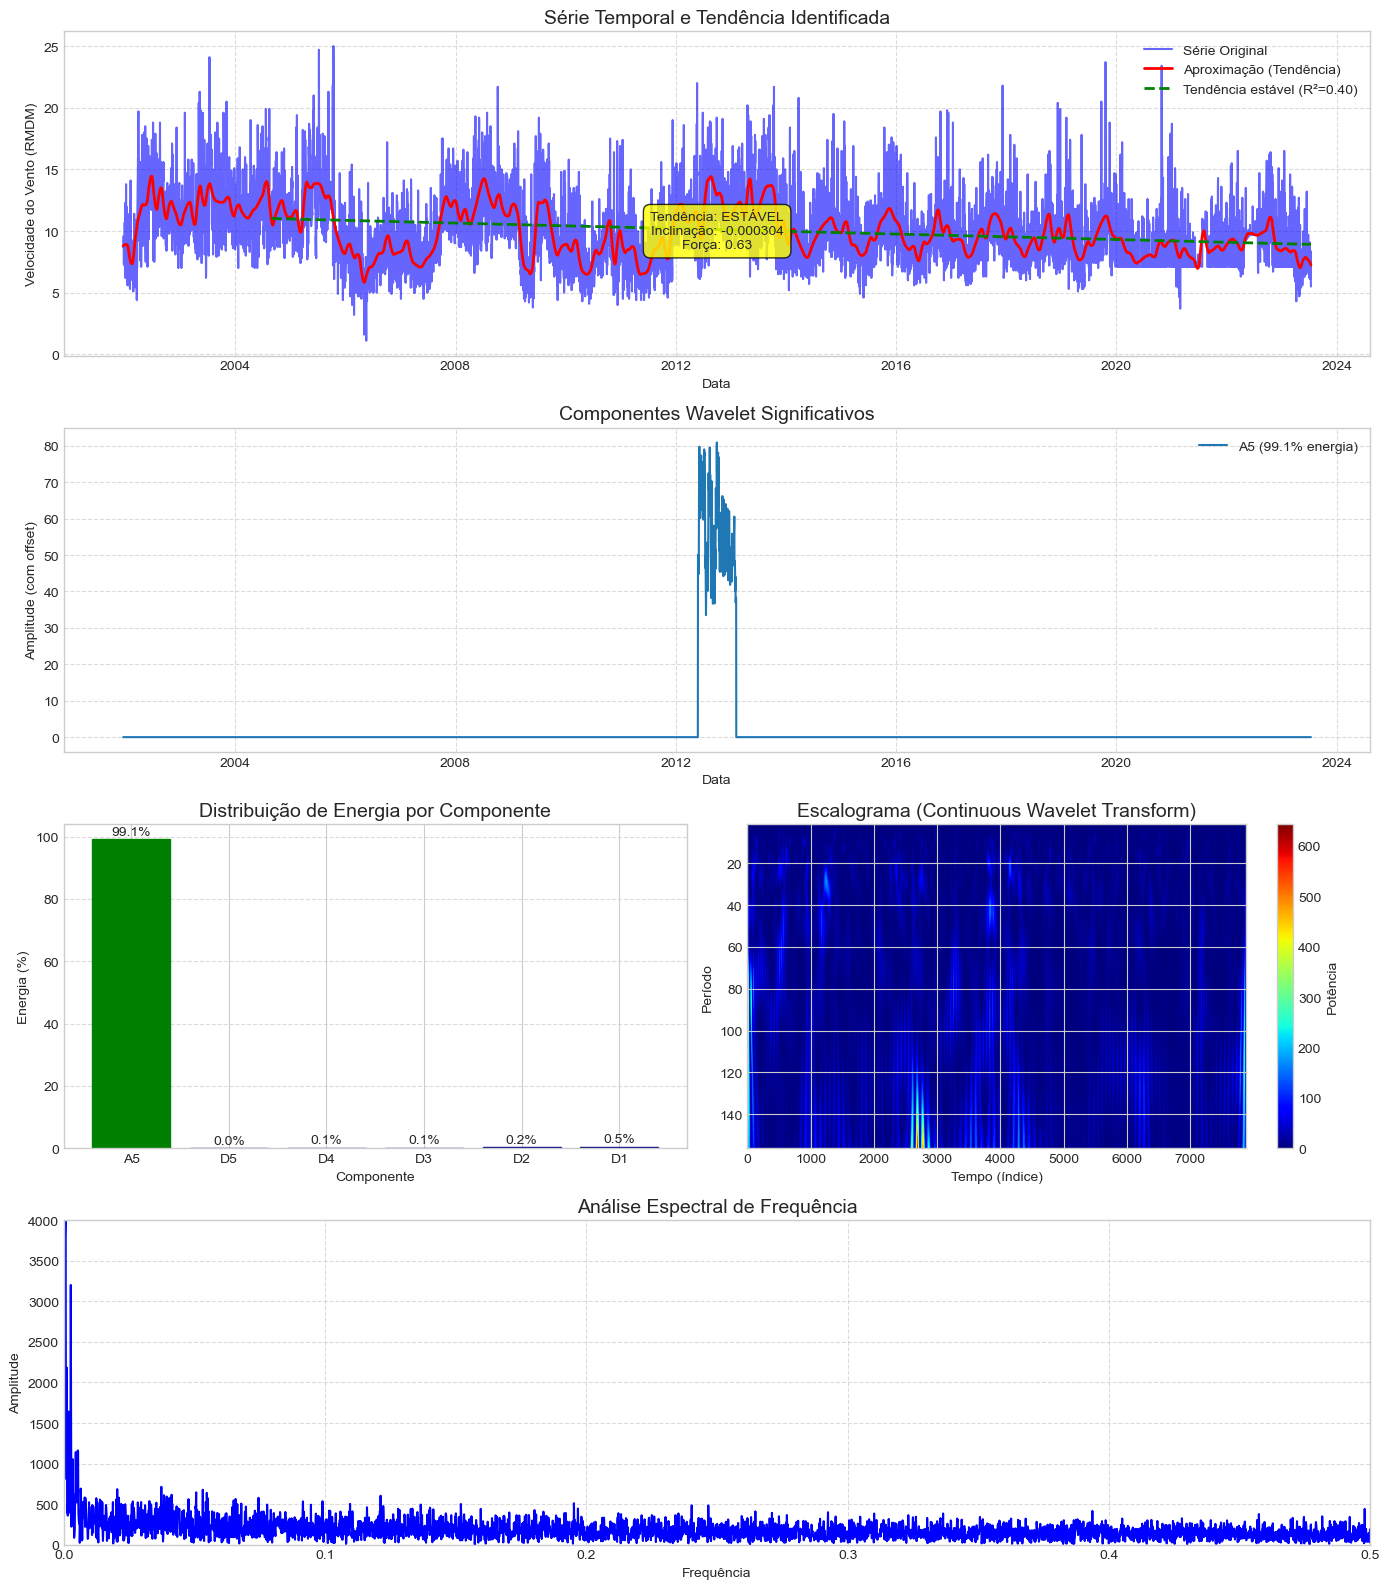


‚úÖ An√°lise conclu√≠da com sucesso!


In [16]:

if __name__ == "__main__":
    main()